#  Laden der Daten

https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

Zunächst müssen die Daten zum Training geladen werden. Die einzelnen Dateien müssen dafür nach Klassen sortiert in Ordner vorhanden sein. <br>
* \Data
   * \Chihuahuas 
      *  img1.jpg
      *  img2.jpg
      *  img3.jpg 
   * \Muffins
       * img1.jpg 
       * img2.jpg 
       * img3.jpg 

 
 Bilddateien aus diesen Ordnern werden geladen, skaliert und ein Array mit entsprechenden Labels erstellt.

In [1]:
import numpy as np

dataset= np.load('dog-vs-muffins.npz')
labels, images, = [dataset[f] for 
                 f in dataset.files]
images= np.concatenate((images[labels ==0][:20], images[labels ==1][:20]) ,axis=0)
labels= np.concatenate((labels[labels ==0][:20], labels[labels ==1][:20]) ,axis=0)
print('load %d files' %len(labels))

load 40 files


In [2]:
def plot(images_to_plot, predictions= np.array([]), titles=[]):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(images_to_plot)):
        ax = fig.add_subplot(4, 4, 1 + i, xticks=[], yticks=[])
        im = images_to_plot[i]
        if titles:
            ax.set_title(titles[i])
        if predictions.size:
            ax.set_xlabel('dog: %6.2f \n muffin %6.2f'
                      % (predictions[i][0], predictions[i][1]), fontsize=12)
        plt.imshow(im)
    
    plt.tight_layout()
    plt.show()



16


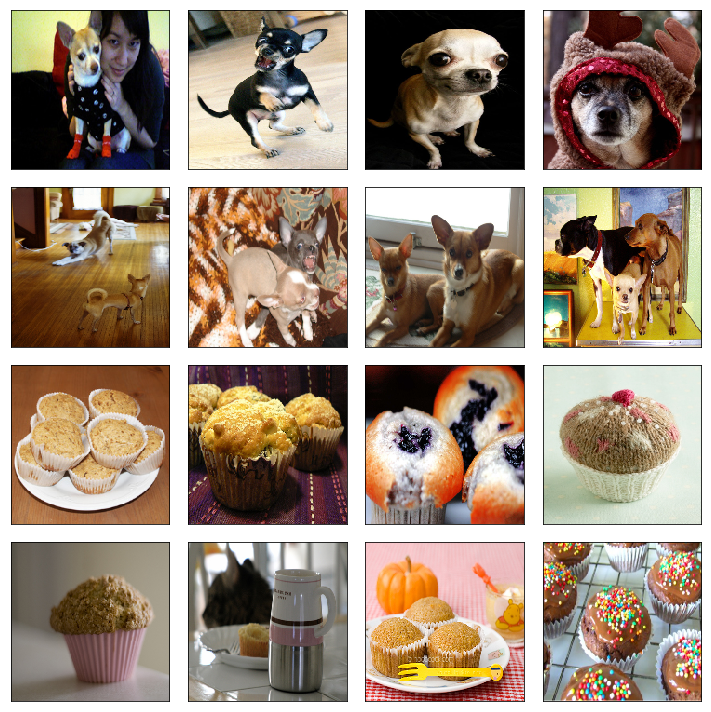

In [3]:
import matplotlib.pyplot as plt
images_to_show= np.concatenate((images[labels ==0][:8], images[labels ==1][:8]) ,axis=0)
print(len(images_to_show))

plot(images_to_show)


# Image Augmentation

Zur Vergrößerung der Datenmenge werden die Images bearbeitet. Für dieses Beispiel werden die Bilder vertikal oder horizontal gespiegelt.

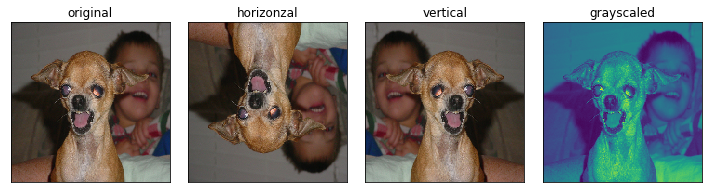

In [4]:
import cv2

img= images[10]

horizontal_flipt= cv2.flip(img, 0)
vertical_flipt= cv2.flip(img, 1)
gray_scaled_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

augmented_images= [img, horizontal_flipt, vertical_flipt, gray_scaled_img]
titels=['original', 'horizonzal', 'vertical', 'grayscaled']
plot(augmented_images, titles=titels)

for index in range(len(images)):
    img = images[index]
    rnd_int=  np.random.randint(0,2)
    
    if rnd_int==0:
        flipt_img= cv2.flip(img, np.random.randint(0,1))
    if rnd_int==1:
        gray_scaled_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)



Zum lernen müssen die Daten durchmischt werden 

In [5]:
from sklearn.utils import shuffle
images , labels = shuffle(images , labels, random_state=9)

Anschließend werden die Daten in eine Trainings-, Validierungs- und Teststichprobe aufgeteilt. 
Trainings und Validierungsstichprobe werden zum anpassen der Gewichte beim Lernen verwendet. 
Die Teststichprobe muss vor der Trainingsphase abgespalten werden und dient dazu den Klassifikator nach dem Training 
zu bewerten.

In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

length=len(labels)

X_train = images[:int(length*0.8)]
X_val   = images[int(length*0.8):int(length*0.9)]
X_test  = images[int(length*0.9):]
y_train = labels[:int(length*0.8)] 
y_val   = labels[int(length*0.8):int(length*0.9)]
y_test  = labels[int(length*0.9):]

y_train= np_utils.to_categorical(y_train, 2)
y_val = np_utils.to_categorical(y_val, 2)

print("Trainingsdaten:", X_train.shape)
print("Validierungsdaten:", X_val.shape)
print("Testdaten:", X_test.shape)


Trainingsdaten: (32, 172, 171, 3)
Validierungsdaten: (4, 172, 171, 3)
Testdaten: (4, 172, 171, 3)


In [8]:
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D,  BatchNormalization, Dropout, Flatten, Dense
from keras.optimizers import SGD

model = Sequential()

model.add(Convolution2D(32, (5, 5), activation='relu',kernel_initializer='glorot_uniform', padding='same', input_shape=(172, 171, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3),kernel_initializer='glorot_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3),kernel_initializer='glorot_uniform', activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy',  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 172, 171, 32)      2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 172, 171, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 86, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 85, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 86, 85, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 42, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 42, 32)        9248      
__________

In [9]:
model.fit(X_train, y_train,
          batch_size=16,
          epochs=1,
          validation_data=(X_val,  y_val),
          verbose=1)

Train on 32 samples, validate on 4 samples
Epoch 1/1
32/32 [==============================] - 6s 202ms/step - loss: 0.8939 - acc: 0.5625 - val_loss: 0.7802 - val_acc: 0.0000e+00


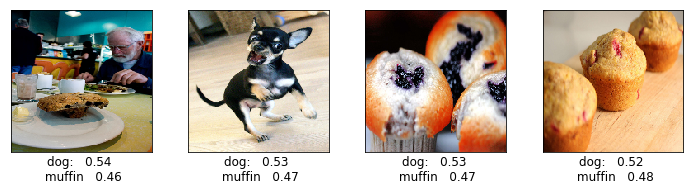

In [11]:

img_to_plot= X_test[:16]
predictions= model.predict(X_test)[:16]

plot(img_to_plot, predictions= predictions)


In [42]:
true_labels=np_utils.to_categorical(y_test, 2)
metric= model.evaluate(X_test, true_labels)

print('loss: %10.2f  \naccuracy: %6.2f' % (metric[0], metric[1]))

4/4 [==============================] - 0s 62ms/step
loss:       0.72  
accuracy:   0.25


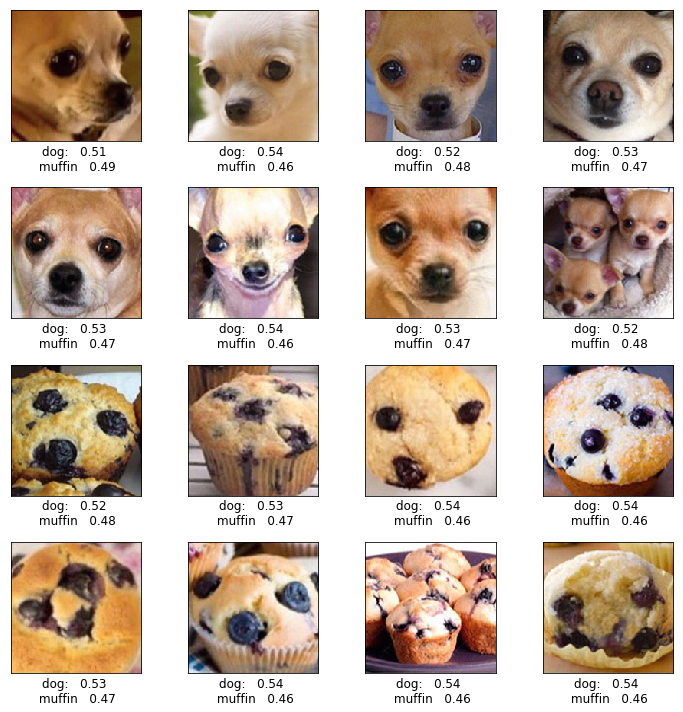

In [34]:
dataset= np.load('test_data.npz')
labels, images= [dataset[f] for 
                 f in dataset.files]

plot(images, predictions= model.predict(images))


In [43]:
true_labels=np_utils.to_categorical(labels, 2)
metric= model.evaluate(images, true_labels)

print('loss: %10.2f  \naccuracy: %6.2f' % (metric[0], metric[1]))

16/16 [==============================] - 1s 60ms/step
loss:       0.70  
accuracy:   0.50
